# Components of a Trading Strategy

#### Indicators
Indicators are mathematical calculations based on historical price, volume, or open interest information that traders use to predict future price movements. Some common types include:
- **Trend Indicators**: Moving Averages (SMA, EMA), Moving Average Convergence Divergence (MACD)
- **Momentum Indicators**: Relative Strength Index (RSI), Stochastic Oscillator
- **Volatility Indicators**: Bollinger Bands, Average True Range (ATR)
- **Volume Indicators**: On-Balance Volume (OBV), Volume Weighted Average Price (VWAP)

**SEE NOTEBOOK NUMBER 02**


#### Entry Point
The entry point is the specific price or condition under which you decide to enter a trade. Key considerations for determining entry points include:
- **Signal from Indicators**: A buy signal from indicators like RSI below 30 (oversold conditions) or a bullish crossover in MACD.
- **Price Action**: Patterns such as breakouts, reversals, or trend continuation patterns (e.g., head and shoulders, flags, triangles).
- **Support and Resistance Levels**: Entering a trade when the price bounces off support or breaks through resistance.

#### Exit Point
The exit point is the specific price or condition under which you decide to close a trade. Key considerations for determining exit points include:
- **Signal from Indicators**: A sell signal from indicators like RSI above 70 (overbought conditions) or a bearish crossover in MACD.
- **Price Action**: Patterns indicating potential reversals or exhaustion.
- **Profit Targets and Stop Losses**: Predefined levels to take profit or limit losses, often based on technical levels (e.g., Fibonacci retracement levels) or a fixed percentage.



In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import itertools

pd.set_option('display.max_row',None)
pd.set_option('display.max_columns',None)

In [2]:
plt.style.use('seaborn-v0_8')

# Buy and hold Strategy 


In [3]:
cours = 'BTC-EUR'
actif = yf.Ticker(cours)
hist = actif.history(period="max",interval='1d')

Failed to get ticker 'BTC-EUR' reason: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v8/finance/chart/BTC-EUR?range=1d&interval=1d (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
BTC-EUR: No timezone found, symbol may be delisted


In [207]:
hist = pd.read_csv('BTC-EUR.csv')
hist['Date'] = pd.to_datetime(hist['Date'])
hist = hist.set_index('Date')

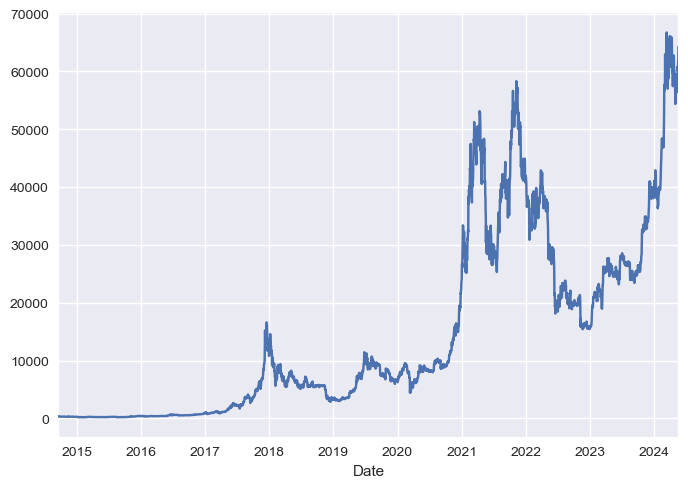

In [124]:
hist['Close'].plot()
plt.show()

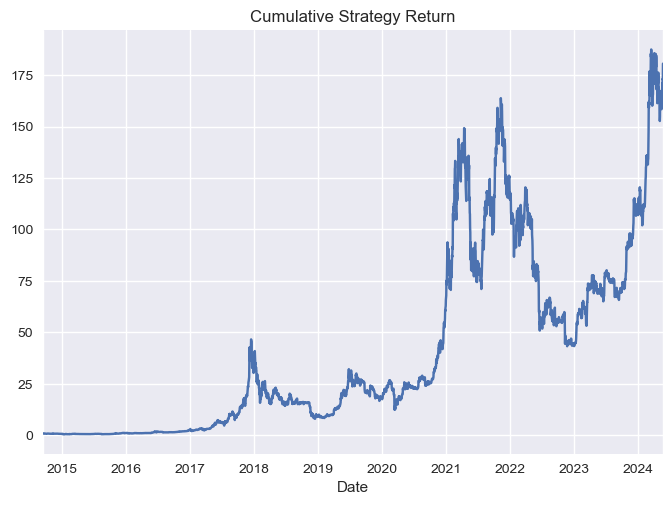

In [125]:
plt.title('Cumulative Strategy Return')
(1+hist['Close'].pct_change()).cumprod().plot()
plt.show()

In [126]:
cumulative_returns = hist.iloc[-1]['Close']/hist.iloc[0]['Close']
print(f"Cumulative Strategy Returns: {cumulative_returns:.2f}")

Cumulative Strategy Returns: 180.56


# Baseline Strategy 

## "Buy low, Sell high"

The most basic trading strategy is to buy when the asset is growing and sell when the asset is falling. To implement this, we use a 28-day rolling maximum and minimum to determine the recent highs and lows of the asset's price.

We define "close" to the recent minimum or maximum using a threshold percentage. For example, if the current price is within 5% of the 28-day rolling minimum, we generate a buy signal. Similarly, if the current price is within 5% of the 28-day rolling maximum, we generate a sell signal.


#### Signal

- **BUY** = if the current price is within 5% of the 28-day rolling minimum
- **SELL** = if the current price is within 5% of the 28-day rolling maximum,  Additionally, we also generate a sell signal if the current price drops more than 5% from the highest price since the buy signal (trailing stop loss)

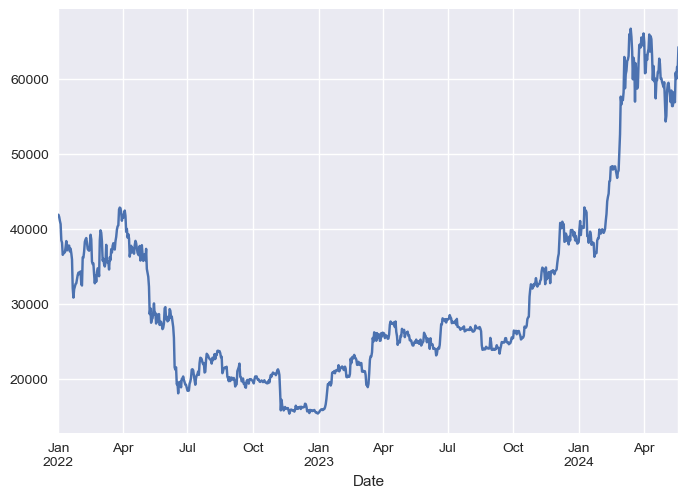

In [127]:
hist['Close'].loc['2022-01':].plot()
plt.show()

In [43]:
def calculate_rolling_extremes(df, window=5):
    df['RollingMax'] = df['Close'].shift(1).rolling(window=window).max()
    df['RollingMin'] = df['Close'].shift(1).rolling(window=window).min()
    return df

def generate_signals(df, threshold_pct=0.05):
    df['Buy'] = np.where(df['Close'] < df['RollingMin'] * (1 + threshold_pct), 1, 0)
    df['Sell'] = np.where(df['Close'] > df['RollingMax'] * (1 - threshold_pct), -1, 0)
    return df

def apply_strategy(df, threshold_pct=0.05):
    df = df.reset_index()
    # when you have the signal you buy at the price of the day after
    df['day_after'] = df['Date'].shift(-1)
    df['buy_price'] = df['Open'].shift(-1)
    holding = False
    trade = {}
    trades = []
    for i, row in df.iterrows():
        if row['Buy'] == 1 and not holding:
            holding = True
            stop_loss_price = row['buy_price'] * (1 - threshold_pct)
            trade['entry_date'] = row['day_after']
            trade['entry_price'] = row['buy_price']

        if holding:
            # Compare current close with actual SL price 
            if row['Close'] > stop_loss_price / (1 - threshold_pct):
                # Update SL
                stop_loss_price = row['Close'] * (1 - threshold_pct)
            
            # Condition to Sell bellow SL
            if row['Close'] < stop_loss_price or row['Sell'] == 1:
                holding = False
                trade['exit_date'] = row['day_after']
                trade['exit_price'] = row['buy_price'] 
                trades.append(trade) 
                trade = {}
    return df,trades


def showtrades(trades,Close,annot=False):
    # Convert date columns to datetime
    trades['entry_date'] = pd.to_datetime(trades['entry_date'])
    trades['exit_date'] = pd.to_datetime(trades['exit_date'])
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot each trade
    for i, row in trades.iterrows():
        color = 'g' if row['exit_price'] > row['entry_price'] else 'r'
        ax.plot([row['entry_date'], row['exit_date']], [row['entry_price'], row['exit_price']], marker='o', color=color)
    
    # Highlight entry and exit points
    ax.scatter(trades['entry_date'], trades['entry_price'], color='blue', label='Entry Points')
    ax.scatter(trades['exit_date'], trades['exit_price'], color='purple', label='Exit Points')
    ax.plot(Close,alpha=0.4)
    
    if annot:
        # Adding annotations for each trade
        for i, row in trades.iterrows():
            ax.annotate(f'{row["entry_price"]:.2f}', xy=(row['entry_date'], row['entry_price']), xytext=(10, 5), textcoords='offset points', fontsize=8, color='blue')
            ax.annotate(f'{row["exit_price"]:.2f}', xy=(row['exit_date'], row['exit_price']), xytext=(10, 5), textcoords='offset points', fontsize=8, color='purple')
        
    # Formatting the plot
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_title('Trade Entries and Exits', fontsize=16)
    ax.legend()
    ax.grid(True)
    
    # Rotate date labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()

In [224]:
df = calculate_rolling_extremes(hist, window=5)
df = generate_signals(df, threshold_pct=0.05)
df,trades = apply_strategy(df, threshold_pct=0.05)

In [228]:
trades = pd.DataFrame(trades)

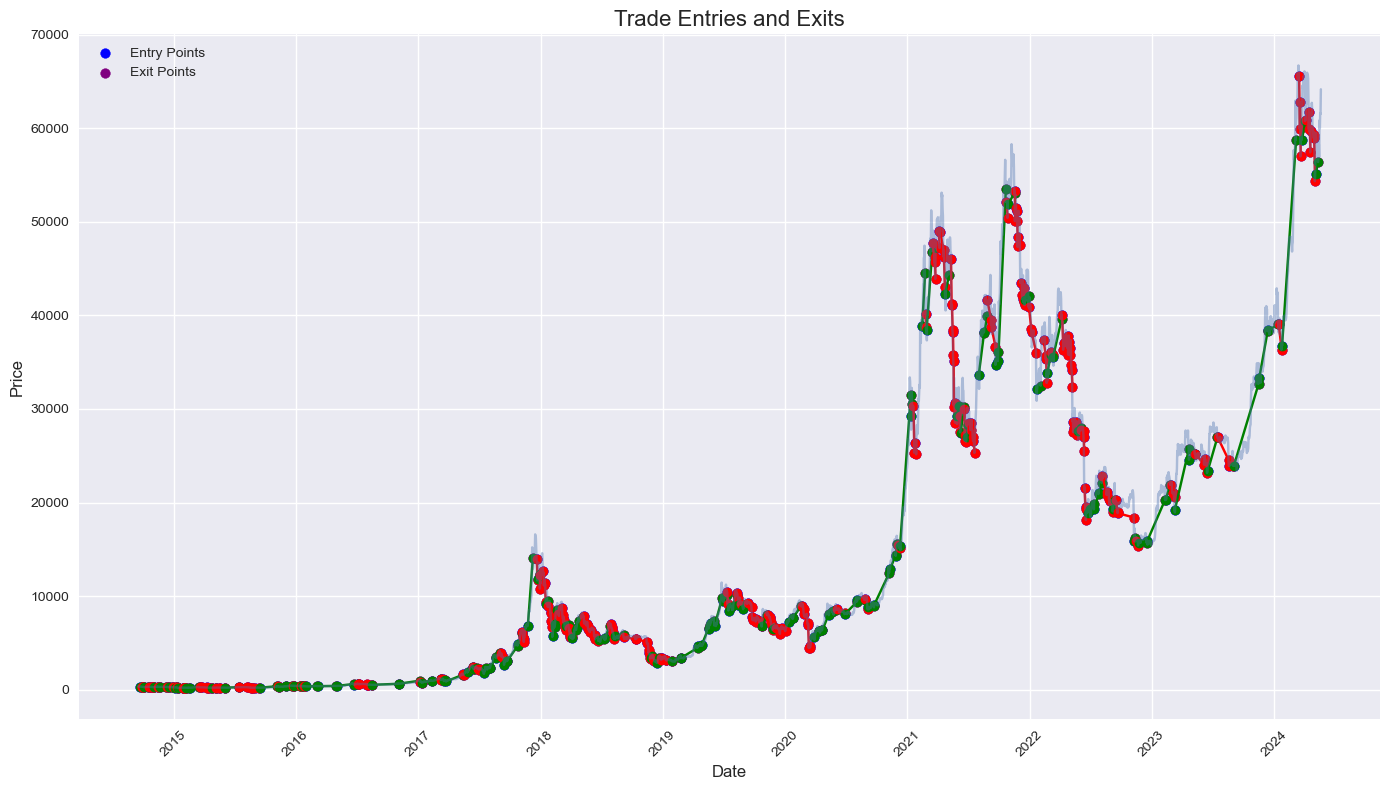

In [255]:
showtrades(trades = trades,Close = hist['Close'], annot=False)

In [49]:
def performance_df(trades):
    # Calculate returns for each trade
    trades['return'] = (trades['exit_price'] - trades['entry_price']) / trades['entry_price']
    trades['holding_time'] = (trades['exit_date'] - trades['entry_date']).dt.days

    # Calculate performance metrics
    win_rate = (trades['return'] > 0).mean()
    cum_return = (1 + trades['return']).prod() - 1
    std_dev = trades['return'].std()
    sharpe_ratio = trades['return'].mean() / trades['return'].std() * np.sqrt(len(trades))
    buy_and_hold_return = (trades['exit_price'].iloc[-1] - trades['entry_price'].iloc[0]) / trades['entry_price'].iloc[0]
    avg_holding_time = trades['holding_time'].mean()

    # Calculate maximum drawdown
    trades['cumulative_return'] = (1 + trades['return']).cumprod()
    cumulative_max = trades['cumulative_return'].cummax()
    drawdown = (trades['cumulative_return'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # Report performance
    performance_report = pd.DataFrame({
        'Metric': ['Win Rate', 'Standard Deviation', 'Sharpe Ratio', 'Buy and Hold Return', 'Cumulative Return', 'Average Holding Time', 'Max Drawdown'],
        'Value': [win_rate, std_dev, sharpe_ratio, buy_and_hold_return, cum_return, avg_holding_time, max_drawdown]
    })

    return performance_report

In [267]:
print(performance_report)

                Metric       Value
0             Win Rate    0.406475
1   Standard Deviation    0.173622
2         Sharpe Ratio    2.712081
3  Buy and Hold Return  179.245631
4    Cumulative Return   95.252609


In [271]:
# Perform backtesting
print(f"Cumulative Strategy Returns: {cum_return:.2f}")

Cumulative Strategy Returns: 95.25


# SMA Strategy

## Moving Average Crossover Strategy

The Moving Average Crossover strategy is based on the crossover of short-term and long-term moving averages. This strategy aims to identify the start of a trend.

### Strategy Description

The Moving Average Crossover strategy involves two main components:
1. **Short-term Moving Average (SMA)**: A shorter period moving average (e.g., 50-day SMA).
2. **Long-term Moving Average (SMA)**: A longer period moving average (e.g., 200-day SMA).

****Recommended SMA Windows****

**Combination 1:**
- Short Window: 7 days
- Long Window: 50 days

**Combination 2:**
- Short Window: 10 days
- Long Window: 50 days

**Combination 3:**
- Short Window: 14 days
- Long Window: 100 days

**Combination 4:**
- Short Window: 20 days
- Long Window: 100 days

**Combination 5:**
- Short Window: 20 days
- Long Window: 50 days



#### Signal

- **BUY** = when the short-term SMA crosses above the long-term SMA (Golden Cross).
- **SELL** = when the short-term SMA crosses below the long-term SMA (Death Cross).

In [159]:
def calculate_sma(df, short_window=7, long_window=50):
    df['Short_SMA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_SMA'] = df['Close'].rolling(window=long_window).mean()
    return df

def generate_sma_signals(df):
    df['Buy'] = np.where((df['Short_SMA'] > df['Long_SMA']) & (df['Short_SMA'].shift(1) <= df['Long_SMA'].shift(1)), 1, 0)
    df['Sell'] = np.where((df['Short_SMA'] < df['Long_SMA']) & (df['Short_SMA'].shift(1) >= df['Long_SMA'].shift(1)), -1, 0)
    return df


def apply_strategy(df):
    df = df.reset_index()
    # When you have the signal you buy at the price of the day after
    df['day_after'] = df['Date'].shift(-1)
    df['buy_price'] = df['Open'].shift(-1)
    
    holding = False
    trade = {}
    trades = []

    for i, row in df.iterrows():
        if row['Buy'] == 1 and not holding:
            holding = True
            trade = {
                'entry_date': row['day_after'],
                'entry_price': row['buy_price']
            }

        if holding and row['Sell'] == -1:
            holding = False
            trade['exit_date'] = row['day_after']
            trade['exit_price'] = row['buy_price']
            trades.append(trade)
            trade = {}
    return df, trades

In [160]:
df = calculate_sma(hist)
df = generate_sma_signals(df)
df, trades = apply_strategy(df)

In [161]:
trades = pd.DataFrame(trades)

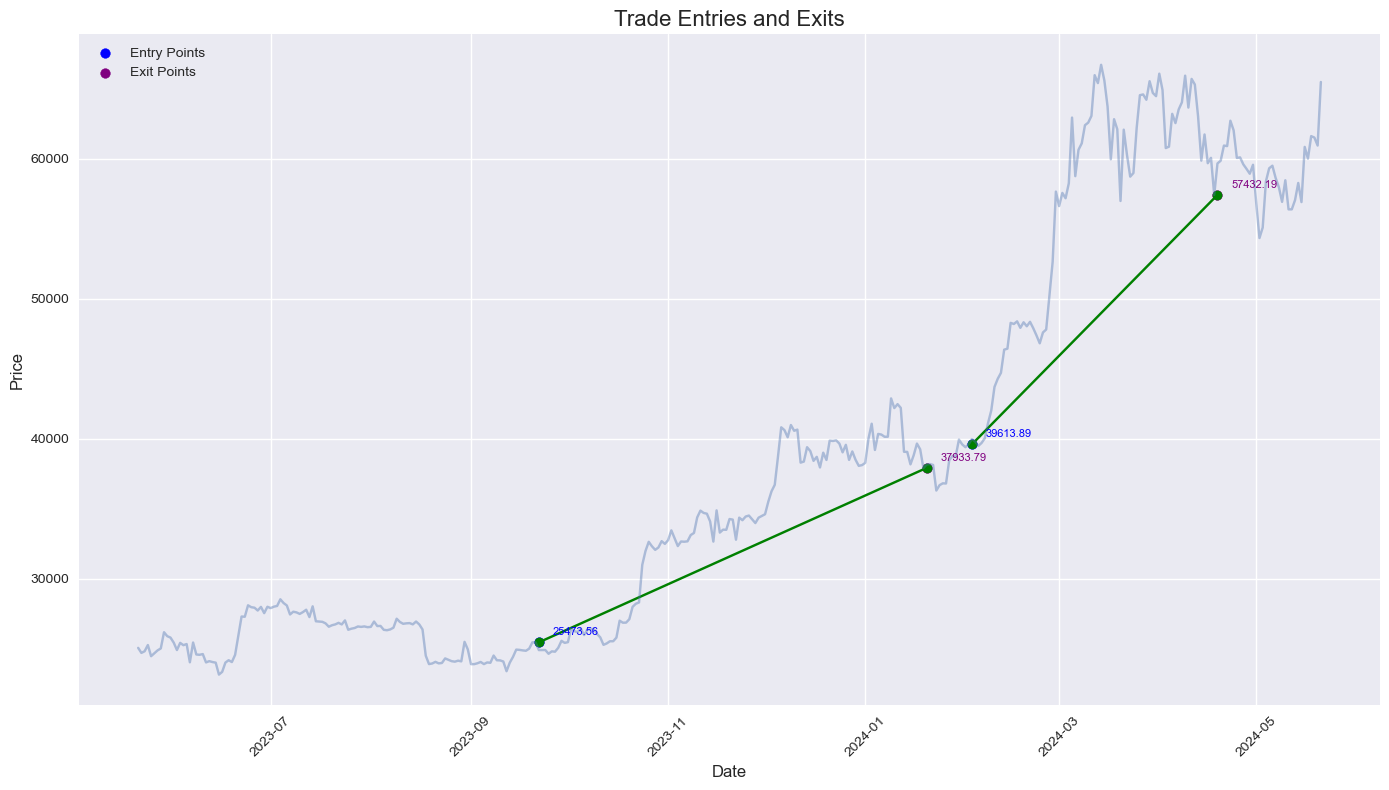

In [162]:
showtrades(trades = trades,Close = hist['Close'], annot=True)

In [163]:
performance_df(trades)

,Metric,Value
0,Win Rate,1.000000
1,Standard Deviation,0.027821
2,Sharpe Ratio,23.864711
3,Buy and Hold Return,1.254580
4,Cumulative Return,1.158959
5,Average Holding Time,98.000000
6,Max Drawdown,0.000000


# MACD Strategy 

The MACD (Moving Average Convergence Divergence) strategy is a popular technical analysis tool used to identify changes in the strength, direction, momentum, and duration of a trend in a stock's price. This strategy uses the difference between a short-term exponential moving average (EMA) and a long-term EMA to generate buy and sell signals.

### Strategy Description

The MACD strategy involves three main components:
1. **MACD Line**: The difference between the 12-day EMA and the 26-day EMA.
2. **Signal Line**: A 9-day EMA of the MACD line.
3. **Histogram**: The difference between the MACD line and the Signal line.

#### Signal

- **BUY** = when the MACD line crosses above the Signal line.
- **SELL** = when the MACD line crosses below the Signal line.


In [89]:
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    df[f'EMA{short_window}'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df[f'EMA{long_window}'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df[f'EMA{short_window}'] - df[f'EMA{long_window}']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    df['Histogram'] = df['MACD'] - df['Signal_Line']
    return df

def generate_macd_signals(df):
    df['Buy'] = np.where((df['MACD'] > df['Signal_Line']) & (df['MACD'].shift(1) <= df['Signal_Line'].shift(1)), 1, 0)
    df['Sell'] = np.where((df['MACD'] < df['Signal_Line']) & (df['MACD'].shift(1) >= df['Signal_Line'].shift(1)), -1, 0)
    return df

def apply_strategy(df):
    df = df.reset_index()
    # When you have the signal you buy at the price of the day after
    df['day_after'] = df['Date'].shift(-1)
    df['buy_price'] = df['Open'].shift(-1)
    
    holding = False
    trade = {}
    trades = []

    for i, row in df.iterrows():
        if row['Buy'] == 1 and not holding:
            holding = True
            trade = {
                'entry_date': row['day_after'],
                'entry_price': row['buy_price']
            }

        if holding and row['Sell'] == -1:
            holding = False
            trade['exit_date'] = row['day_after']
            trade['exit_price'] = row['buy_price']
            trades.append(trade)
            trade = {}
    return df, trades

In [90]:
df = calculate_macd(hist)
df = generate_macd_signals(df)
df, trades = apply_strategy(df)

In [91]:
trades = pd.DataFrame(trades)

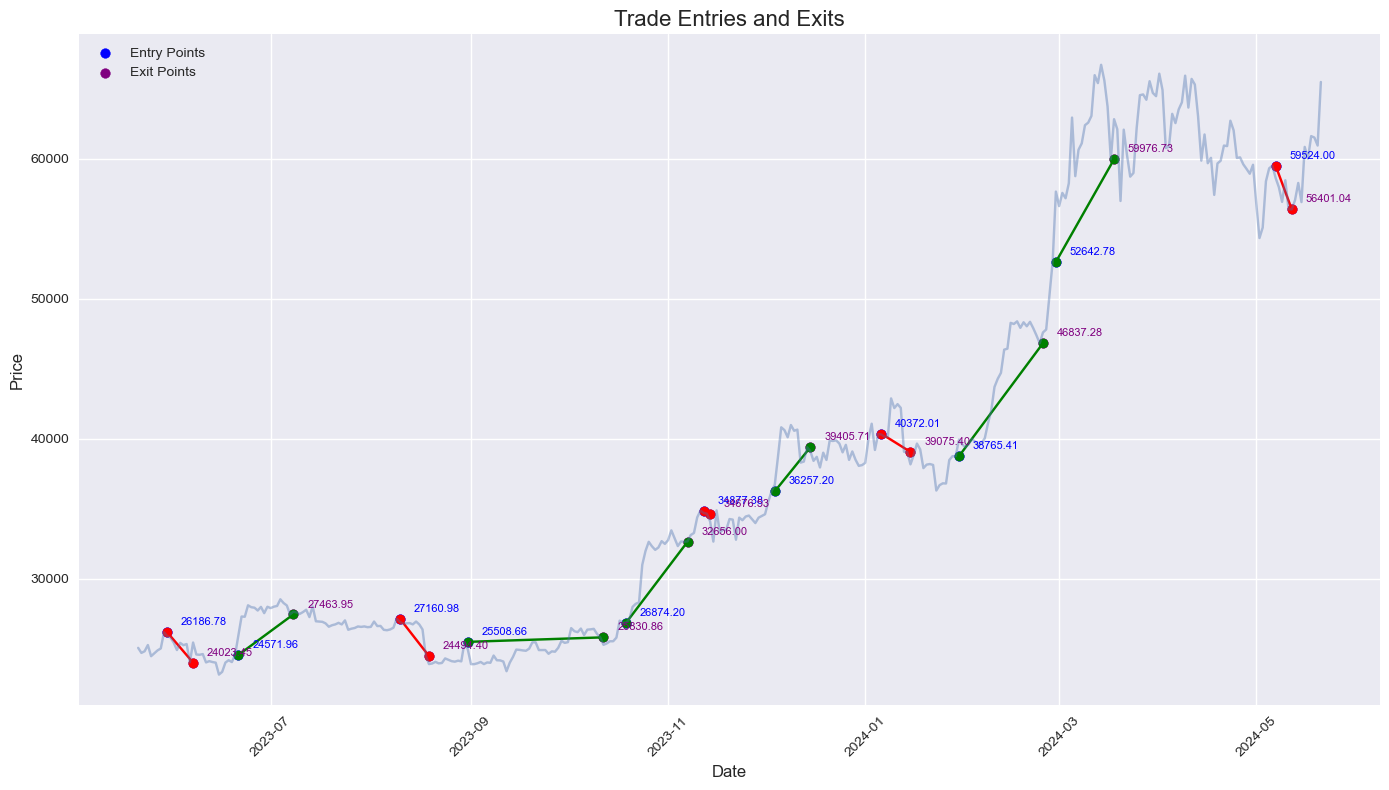

In [93]:
showtrades(trades = trades,Close = hist['Close'], annot=True)

In [94]:
performance_df(trades)

,Metric,Value
0,Win Rate,0.545455
1,Standard Deviation,0.112853
2,Sharpe Ratio,1.359143
3,Buy and Hold Return,1.153798
4,Cumulative Return,0.552182
5,Average Holding Time,15.090909
6,Max Drawdown,-0.098177


# Bollinger Bands Strategy

Bollinger Bands are a popular technical analysis tool that uses a moving average and standard deviations to identify overbought and oversold conditions. This strategy uses Bollinger Bands to generate buy and sell signals based on the price's relative position to the bands.

### Strategy Description

The Bollinger Bands strategy involves three main components:
1. **Middle Band**: A 20-day simple moving average (SMA) of the price.
2. **Upper Band**: The middle band plus 2 standard deviations of the price over the same period.
3. **Lower Band**: The middle band minus 2 standard deviations of the price over the same period.

#### Signal

- **BUY** = when the price crosses above the lower band.
- **SELL** = when the price crosses below the upper band.

In [131]:
def calculate_bollinger_bands(df, window=10, num_std_dev=2):
    df['Middle_Band'] = df['Close'].rolling(window=window).mean()
    df['Std_Dev'] = df['Close'].rolling(window=window).std()
    df['Upper_Band'] = df['Middle_Band'] + (df['Std_Dev'] * num_std_dev)
    df['Lower_Band'] = df['Middle_Band'] - (df['Std_Dev'] * num_std_dev)
    return df

def generate_bollinger_signals(df):
    df['Buy'] = np.where(df['Close'] < df['Lower_Band'], 1, 0)
    df['Sell'] = np.where(df['Close'] > df['Upper_Band'], -1, 0)
    return df

def apply_strategy(df):
    df = df.reset_index()
    # When you have the signal you buy at the price of the day after
    df['day_after'] = df['Date'].shift(-1)
    df['buy_price'] = df['Open'].shift(-1)
    
    holding = False
    trade = {}
    trades = []

    for i, row in df.iterrows():
        if row['Buy'] == 1 and not holding:
            holding = True
            trade = {
                'entry_date': row['day_after'],
                'entry_price': row['buy_price']
            }

        if holding and row['Sell'] == -1:
            holding = False
            trade['exit_date'] = row['day_after']
            trade['exit_price'] = row['buy_price']
            trades.append(trade)
            trade = {}
    return df, trades

In [132]:
df = calculate_bollinger_bands(hist)
df = generate_bollinger_signals(df)
df, trades = apply_strategy(df)

In [133]:
trades = pd.DataFrame(trades)

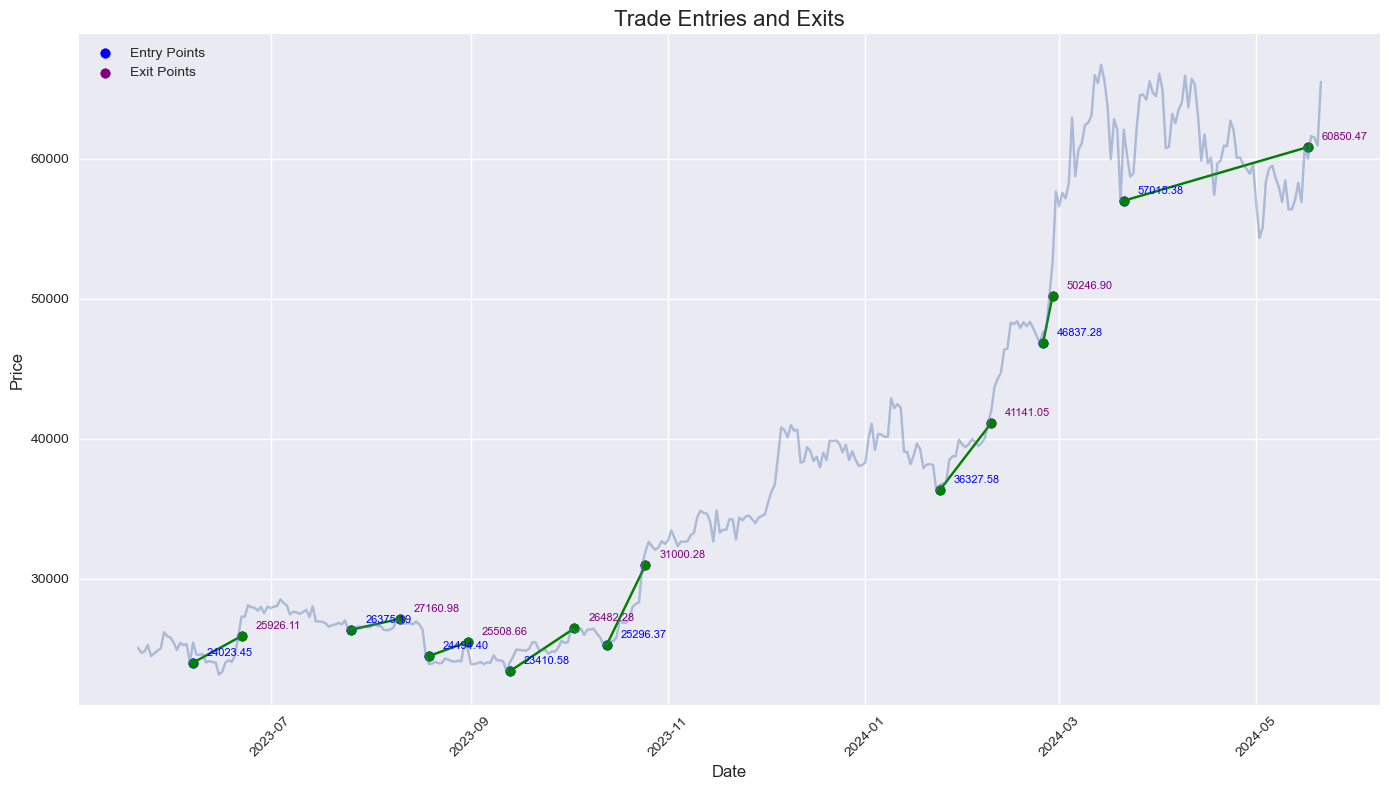

In [135]:
showtrades(trades = trades,Close = hist['Close'], annot=True)

In [122]:
performance_df(trades)

,Metric,Value
0,Win Rate,1.000000
1,Standard Deviation,0.063618
2,Sharpe Ratio,4.332867
3,Buy and Hold Return,1.532962
4,Cumulative Return,1.080424
5,Average Holding Time,18.750000
6,Max Drawdown,0.000000


## RSI Strategy

The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. The RSI ranges from 0 to 100 and is typically used to identify overbought or oversold conditions in a market.

### Strategy Description

The RSI strategy involves calculating the RSI over a specified period (e.g., 14 days) and generating buy and sell signals based on the RSI values.

#### Signal

- **BUY** = when the RSI crosses above 30 (indicating the asset is potentially oversold).
- **SELL** = when the RSI crosses below 70 (indicating the asset is potentially overbought).


In [191]:
def calculate_rsi(df, window=7):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def generate_rsi_signals(df):
    df['Buy'] = np.where((df['RSI'] > 30) & (df['RSI'].shift(1) <= 30), 1, 0)
    df['Sell'] = np.where((df['RSI'] < 70) & (df['RSI'].shift(1) >= 70), -1, 0)
    return df

def apply_strategy(df):
    df = df.reset_index()
    # When you have the signal you buy at the price of the day after
    df['day_after'] = df['Date'].shift(-1)
    df['buy_price'] = df['Open'].shift(-1)
    
    holding = False
    trade = {}
    trades = []

    for i, row in df.iterrows():
        if row['Buy'] == 1 and not holding:
            holding = True
            trade = {
                'entry_date': row['day_after'],
                'entry_price': row['buy_price']
            }

        if holding and row['Sell'] == -1:
            holding = False
            trade['exit_date'] = row['day_after']
            trade['exit_price'] = row['buy_price']
            trades.append(trade)
            trade = {}
    return df, trades


In [192]:
df = calculate_rsi(hist)
df = generate_rsi_signals(df)
df, trades = apply_strategy(df)

In [193]:
trades = pd.DataFrame(trades)

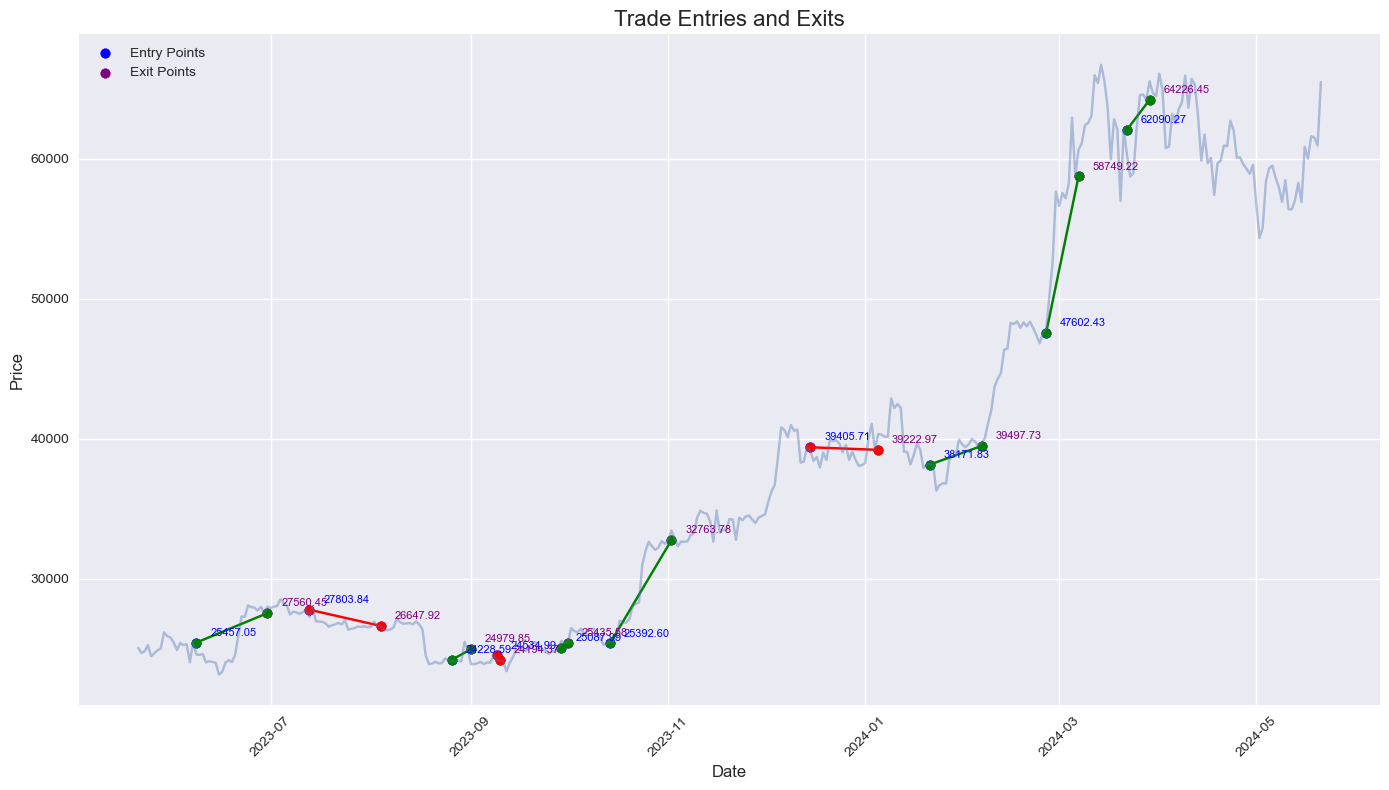

In [194]:
showtrades(trades = trades,Close = hist['Close'], annot=True)

In [195]:
performance_df(trades)

,Metric,Value
0,Win Rate,0.700000
1,Standard Deviation,0.109404
2,Sharpe Ratio,1.910548
3,Buy and Hold Return,1.522933
4,Cumulative Return,0.814526
5,Average Holding Time,12.600000
6,Max Drawdown,-0.041574


# Fibonacci Retracement Strategy with Rolling Windows

Fibonacci Retracement is a popular technical analysis tool that uses horizontal lines to indicate areas of support or resistance at key Fibonacci levels before the price continues in the original direction. These levels are derived from the Fibonacci sequence and are commonly used to identify potential reversal points.

### Strategy Description

The Fibonacci Retracement strategy involves calculating key Fibonacci levels based on a significant price high and low over a rolling window.

### Common Fibonacci Levels

- 23.6%
- 38.2%
- 50.0%
- 61.8%
- 78.6%

#### Signal

- **BUY** = when the price retraces to a Fibonacci support level and shows signs of reversing upwards.
- **SELL** = when the price retraces to a Fibonacci resistance level and shows signs of reversing downwards.



In [235]:
def calculate_fibonacci_retracement(df, window=20):
    # Calculate the rolling maximum and minimum closing prices over the specified window
    df['Rolling_max'] = df['Close'].rolling(window=window).max()
    df['Rolling_min'] = df['Close'].rolling(window=window).min()
   
    # Calculate the difference between the rolling maximum and minimum
    df['diff'] = df['Rolling_max'] - df['Rolling_min']
    
    # Calculate the Fibonacci retracement levels
    df['fibo_level_0'] = df['Rolling_max']
    df['fibo_level_23.6'] = df['Rolling_max'] - 0.236 * df['diff']
    df['fibo_level_38.2'] = df['Rolling_max'] - 0.382 * df['diff']
    df['fibo_level_50'] = df['Rolling_max'] - 0.5 * df['diff']
    df['fibo_level_61.8'] = df['Rolling_max'] - 0.618 * df['diff']
    df['fibo_level_78.6'] = df['Rolling_max'] - 0.786 * df['diff']
    df['fibo_level_100'] = df['Rolling_min']

    return df

# Generate signals
def generate_fibonacci_signals(df):  
    # The buy signal is set when the closing price crosses below a Fibonacci retracement level and then moves back up above it. 
    df['Buy'] = np.where(
        (df['Close'] <= df['fibo_level_78.6']) & (df['Close'].shift(1) > df['fibo_level_78.6']) |
        (df['Close'] <= df['fibo_level_61.8']) & (df['Close'].shift(1) > df['fibo_level_61.8']) |
        (df['Close'] <= df['fibo_level_50']) & (df['Close'].shift(1) > df['fibo_level_50']) |
        (df['Close'] <= df['fibo_level_38.2']) & (df['Close'].shift(1) > df['fibo_level_38.2']) |
        (df['Close'] <= df['fibo_level_23.6']) & (df['Close'].shift(1) > df['fibo_level_23.6']),
        1, 0
    )
    
    # The sell signal is set when the closing price crosses above a Fibonacci retracement level and then moves back down below it.
    df['Sell'] = np.where(
        (df['Close'] >= df['fibo_level_23.6']) & (df['Close'].shift(1) < df['fibo_level_23.6']) |
        (df['Close'] >= df['fibo_level_38.2']) & (df['Close'].shift(1) < df['fibo_level_38.2']) |
        (df['Close'] >= df['fibo_level_50']) & (df['Close'].shift(1) < df['fibo_level_50']) |
        (df['Close'] >= df['fibo_level_61.8']) & (df['Close'].shift(1) < df['fibo_level_61.8']) |
        (df['Close'] >= df['fibo_level_78.6']) & (df['Close'].shift(1) < df['fibo_level_78.6']),
        -1, 0
    )
    
    return df


def apply_strategy(df):
    df = df.reset_index()
    # When you have the signal you buy at the price of the day after
    df['day_after'] = df['Date'].shift(-1)
    df['buy_price'] = df['Open'].shift(-1)
    
    holding = False
    trade = {}
    trades = []

    for i, row in df.iterrows():
        if row['Buy'] == 1 and not holding:
            holding = True
            trade = {
                'entry_date': row['day_after'],
                'entry_price': row['buy_price']
            }

        if holding and row['Sell'] == -1:
            holding = False
            trade['exit_date'] = row['day_after']
            trade['exit_price'] = row['buy_price']
            trades.append(trade)
            trade = {}
    return df, trades

In [248]:
df = calculate_fibonacci_retracement(hist,window=20)
df = generate_fibonacci_signals(df)
df, trades = apply_strategy(df)

In [249]:
trades = pd.DataFrame(trades)

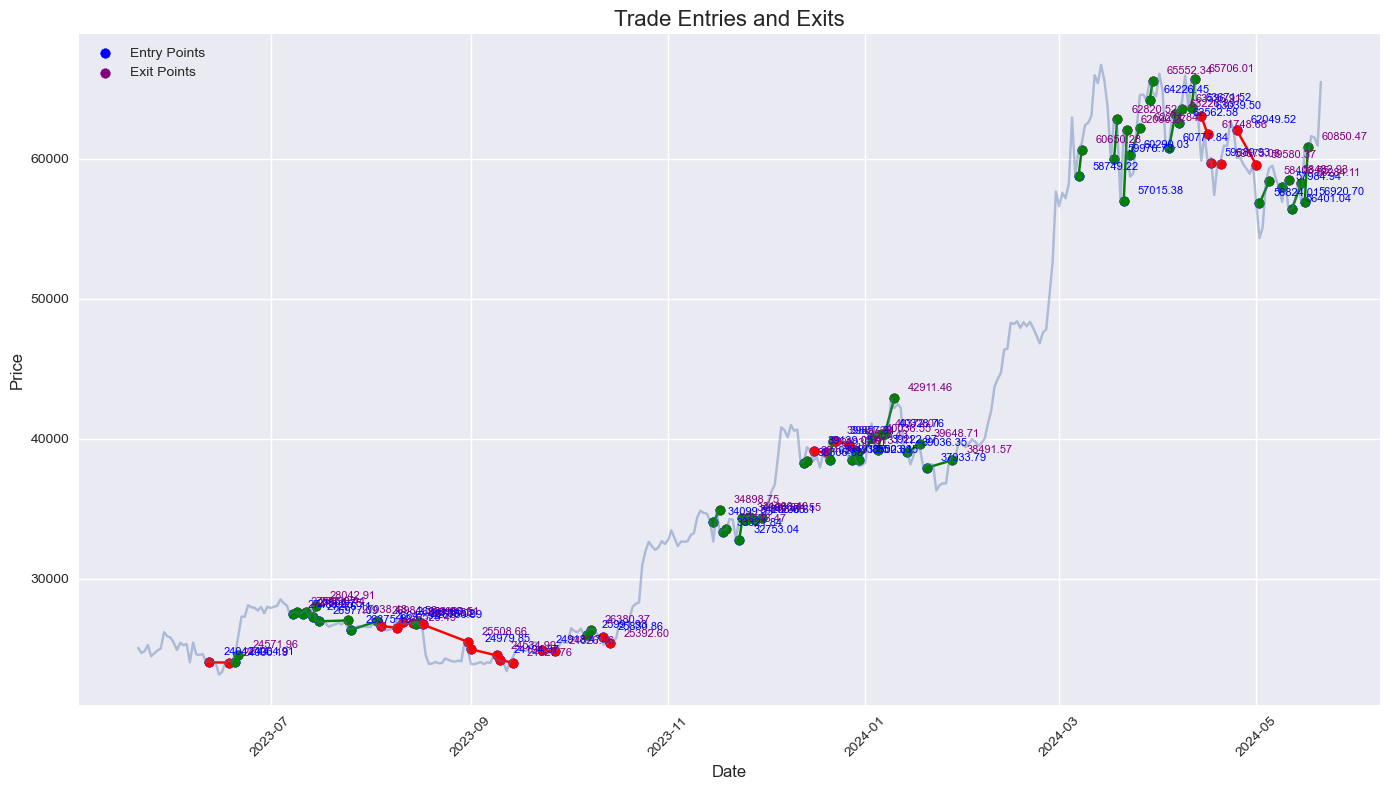

In [250]:
showtrades(trades = trades,Close = hist['Close'], annot=True)

In [251]:
performance_df(trades)

,Metric,Value
0,Win Rate,0.717391
1,Standard Deviation,0.026023
2,Sharpe Ratio,3.944273
3,Buy and Hold Return,1.530961
4,Cumulative Return,0.966409
5,Average Holding Time,3.000000
6,Max Drawdown,-0.075776


# Conclusion

 - With these strategies, we have seen the most common ways to determine how to enter and exit a trade. We observed that in various cases, the indicator is extremely dependent on the parameters. In the next course, we will focus on this part and see how to optimize parameter-based indicators in a system.


**with those strategy we can create a system that is cost efficient**